In [47]:
from pyspark.sql.functions import mean, udf, col, round, isnan, when, count
from pyspark.sql.types import DoubleType
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime 
print(datetime.datetime.now())
%matplotlib inline

sc = SparkContext('local')
spark = SparkSession(sc)

2019-05-29 19:23:14.370363


In [43]:
# spark_session  = SparkSession.builder\
#                         .enableHiveSupport()\
#                         .getOrCreate()

# spark_session.conf.set("spark.executor.memory", '8g')
# spark_session.conf.set('spark.executor.cores', '13')
# spark_session.conf.set('spark.cores.max', '13')
# spark_session.conf.set("spark.driver.memory",'8g')
# sc = spark_session.sparkContext

## import csv files into spark dataframes
Note: both files contain records from all 5 boroughs

In [48]:
# BK = spark.read.csv('data/18v1/BK_18v1.csv', header=True)
# BX = spark.read.csv('data/18v1/BX_18v1.csv', header=True)
# MN = spark.read.csv('data/18v1/MN_18v1.csv', header=True)
# QN = spark.read.csv('data/18v1/QN_18v1.csv', header=True)
# SI = spark.read.csv('data/18v1/SI_18v1.csv', header=True)

df1 = spark.read.csv('../data/pluto.csv', header=True)
df2 = spark.read.csv('../data/pluto_18v2_1.csv', header=True)
# df3 = spark.read.csv('../data/pluto_18v1.csv', header=True)

In [49]:
df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])
# df3 = df3.select([col(A).alias(A.lower()) for A in df3.schema.names])

In [50]:
double_columns = ['bldgarea', 'facilfar',
                  'residfar', 'commfar', 'numbldgs', 'numfloors', 'bldgdepth', 
                  'bldgfront', 'lotdepth', 'lotfront', 
                  'exempttot', 'exemptland',  'assessland', 'assesstot', 'builtfar']

In [51]:
cols = df2.columns

In [52]:
df1 = df1.select(cols)
df2 = df2.select(cols)
# df3 = df3.select(cols)

## Type Conversion

In [53]:
for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))
#     df3 = df3.withColumn(A, round(col(A).cast(DoubleType()), 2))

## Count Null and 0

In [54]:
null_1 = df1.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df1.columns]).toPandas()

In [55]:
null_1

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
0,0,2,2,1948,1948,1948,2586,1948,21489,2621,...,825251,794249,9,1,1,1,1,859922,859930,9


In [56]:
null_2 = df2.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df2.columns]).toPandas()

In [57]:
# null_3 = df3.select([(count(when(isnan(c) | col(c).isNull(), 1))\
#                       + count(when(col(c)==0,1))).alias(c) for c in df3.columns]).toPandas()

In [58]:
# null_all = pd.concat([null_3, null_2, null_1])
null_all = pd.concat([null_2, null_1])
null_change = null_all.pct_change()

In [59]:
null_change.iloc[1,:].sort_values(ascending=False)[0:10]

address       54.535985
plutomapid     9.782051
lotfront       2.888962
lotarea        2.374782
lotdepth       1.443626
ownername      1.437700
taxmap         1.310773
sanitsub       1.309392
tract2010      0.957000
sanborn        0.956044
Name: 0, dtype: float64

In [60]:
# null_change.iloc[2,:].sort_values(ascending=False)[0:10]

In [61]:
null_all.index = ['18v2_1', '19v1']
null_all

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
18v2_1,0,8,8,1000,1000,1000,1638,1000,20541,1673,...,824299,793294,6,6,6,6,6,858982,858982,6
19v1,0,2,2,1948,1948,1948,2586,1948,21489,2621,...,825251,794249,9,1,1,1,1,859922,859930,9


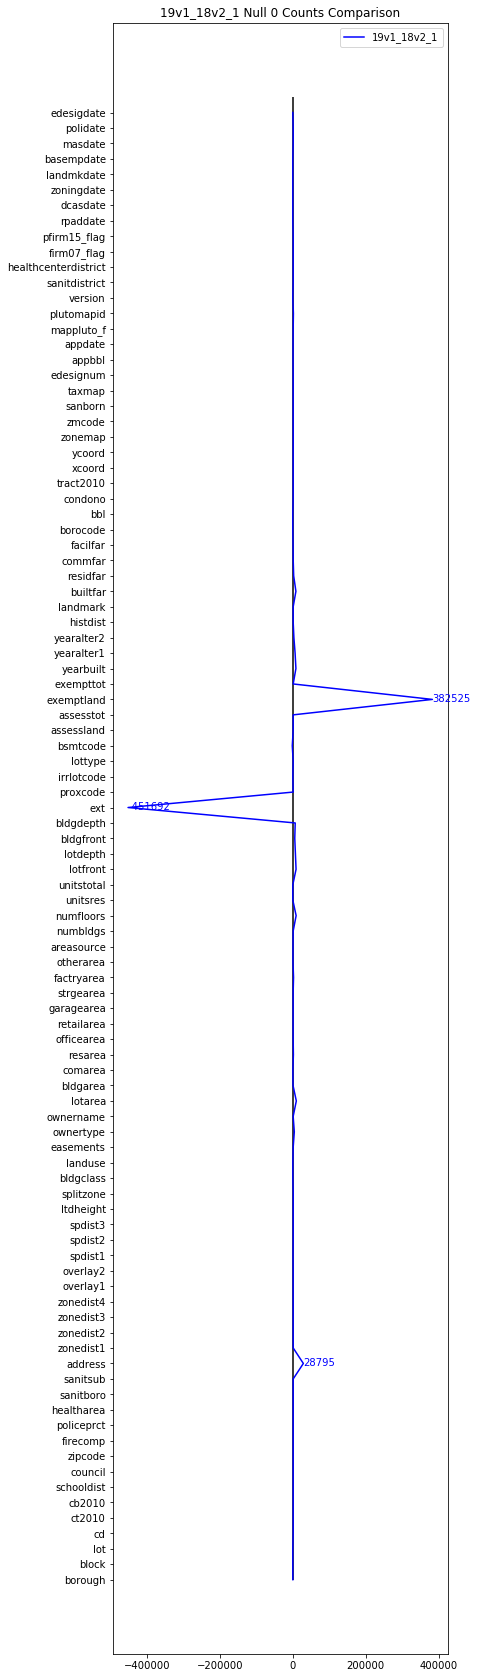

In [62]:
plt.figure(figsize=(6, 30))

difference1 = null_all.iloc[1, :]-null_all.iloc[0, :]
# difference2 = null_all.iloc[2, :]-null_all.iloc[1, :]

plt.plot(difference1, range(96), label = '19v1_18v2_1', color = 'blue')
# plt.plot(difference2, range(96), label = '18v2_18v1', color = 'red')
plt.vlines(0, 0, 96) #0 reference line

for i in range(96):
    if abs(difference1[i]) >= 10000:
        plt.text(x = difference1[i] , y = i - 0.15, s = '{}'.format(difference1[i]), size = 10, color = 'blue')
    else: 
        pass
    
# for i in range(96):
#     if abs(difference1[i]) >= 10000:
#         plt.text(x = difference1[i] , y = i-0.15, s = '{}'.format(difference1[i]), size = 10, color = 'red')
#     else: 
#         pass
    
plt.yticks(range(96), null_all.columns, rotation='horizontal')
# plt.title('19v1_18v2_18v1 Null 0 Counts Comparison')
plt.title('19v1_18v2_1 Null 0 Counts Comparison')
plt.legend()
# plt.savefig('19v1_18v2_18v1_Null0_Comparison.png', bbox_inches='tight')
plt.show()

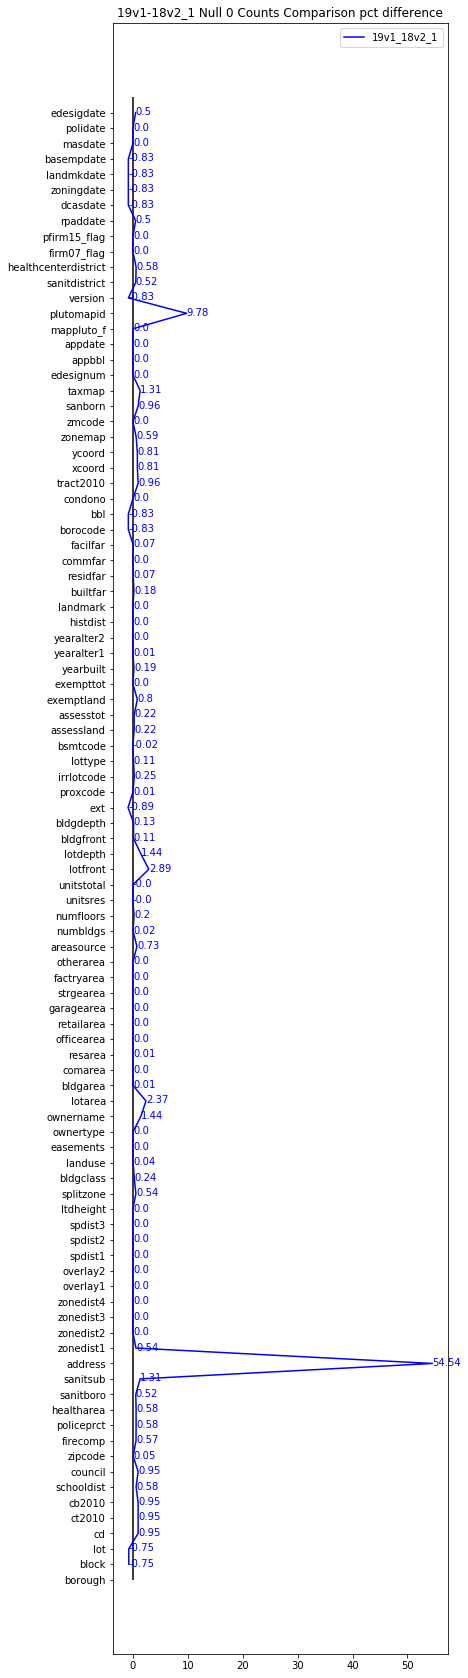

In [63]:
plt.figure(figsize=(6, 30))

plt.plot(null_change.iloc[1,:], range(96), label = '19v1_18v2_1', color = 'blue')
# plt.plot(null_change.iloc[1,:], range(96), label = '18v1_18v2', color = 'red')
plt.vlines(0, 0, 96) #0 reference line

for i in range(96):
    if abs(null_change.iloc[1,i]) <= 100:
        plt.text(x = null_change.iloc[1,i] , y = i - 0.15, s = '{}'.format(np.round(null_change.iloc[1,i], 2)), size = 10, color = 'blue')
    else: 
        pass
    
plt.yticks(range(96), null_all.columns, rotation='horizontal')
plt.title('19v1-18v2_1 Null 0 Counts Comparison pct difference')
plt.legend()
plt.savefig('19v1-18v2_1-Null0-Comparison-pct.png', bbox_inches='tight')
plt.show()